In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,354 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,256 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packa

In [2]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

# Create a SparkSession
spark = SparkSession.builder.appName("Diabetes").getOrCreate()

In [3]:
# Read in data
from pyspark import SparkFiles
url="https://diabetesdataprediction.s3.ca-central-1.amazonaws.com/diabetes.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("diabetes.csv"), header=True, inferSchema=True, quote="\"", escape="\"")
# Show DataFrame
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [4]:
#Remove empty records from the data set
df = df.filter((df.Glucose != 0) & (df.BloodPressure != 0) & (df.SkinThickness != 0) & (df.Insulin != 0) & (df.BMI != 0))
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|
|          2|    197|           70|           45|    543|30.5|                   0.158| 53|      1|
|          1|    189|           60|           23|    846|30.1|                   0.398| 59|      1|
|          5|    166|           72|           19|    175|25.8|                   0.587| 51|      1|
|          0|    118|           84|           47|    230|45.8|                   0.551| 31|      1|


In [5]:
#Create a temporary view.
df.createOrReplaceTempView('Diabetes')

In [6]:
#Identify how many positive and negative diabetic results are in the dataset
result = spark.sql("SELECT COUNT(*) AS number FROM Diabetes GROUP BY Outcome ORDER BY Outcome")
result.toPandas()

,number
0,262
1,130


In [8]:
#Find if all the features affect the diabetes status
result = spark.sql("SELECT Outcome, AVG(SkinThickness), AVG(Insulin), AVG(Glucose), AVG(BloodPressure), AVG(BMI) FROM Diabetes GROUP BY Outcome")
result.toPandas()

,Outcome,avg(SkinThickness),avg(Insulin),avg(Glucose),avg(BloodPressure),avg(BMI)
0,1,32.961538,206.846154,145.192308,74.076923,35.777692
1,0,27.251908,130.854962,111.431298,68.969466,31.750763


In [9]:
#Convert spark df to Pandas Dataframe
Diabetes_df = df.toPandas()

<Axes: >

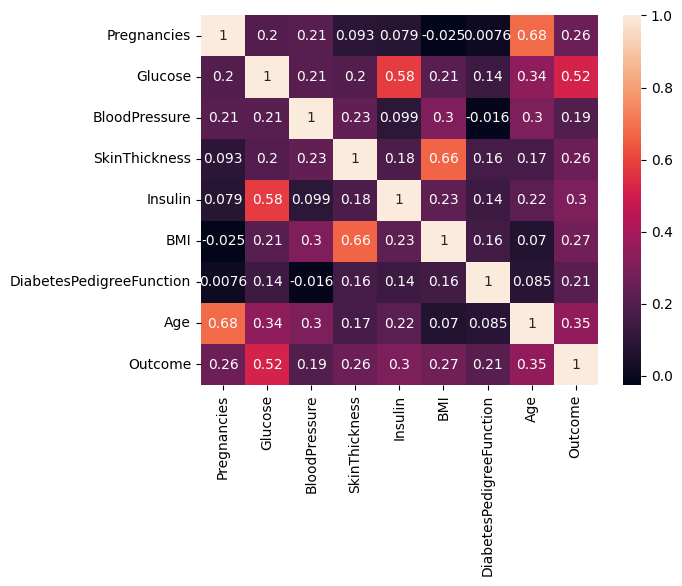

In [10]:
#Create heatmap to get the correlation
import seaborn as sns
sns.heatmap(Diabetes_df.corr(), annot = True)

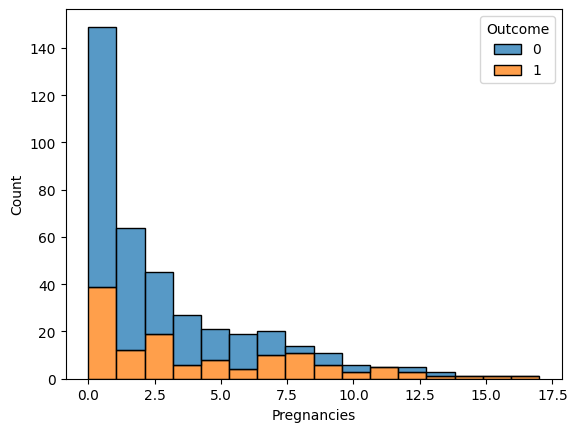

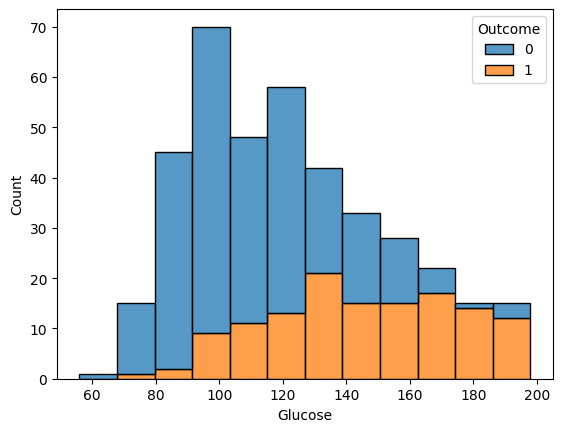

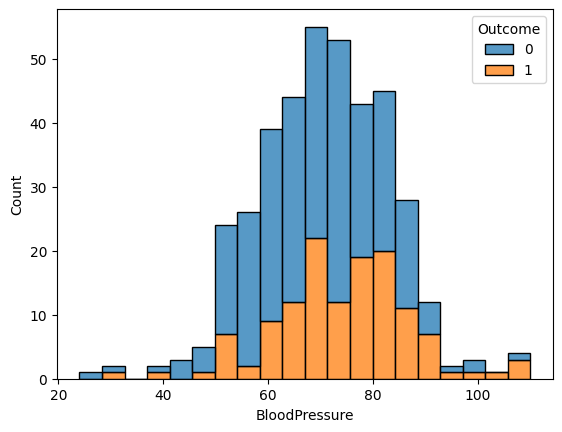

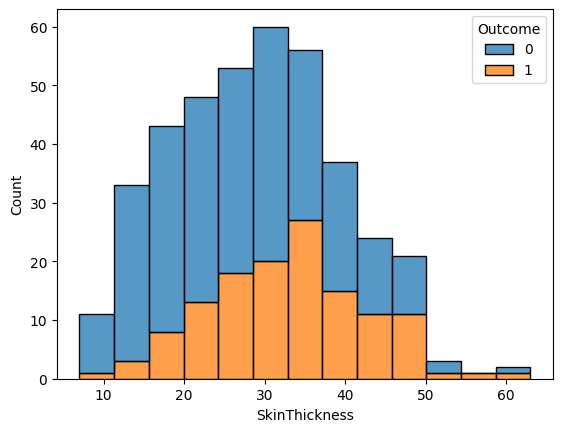

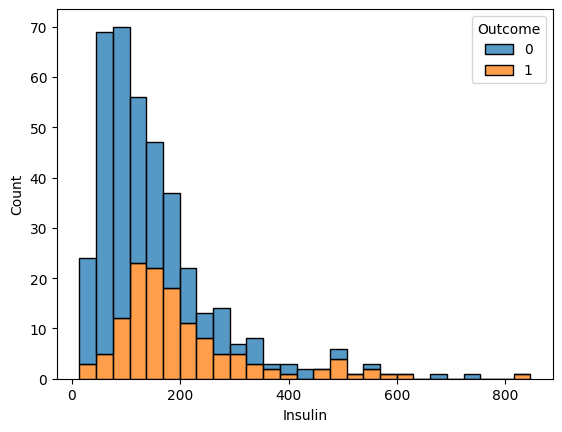

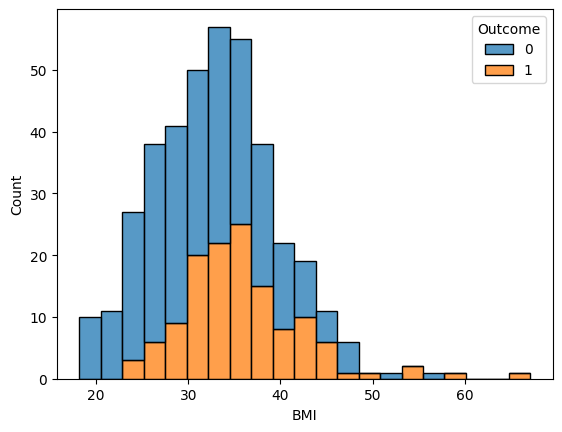

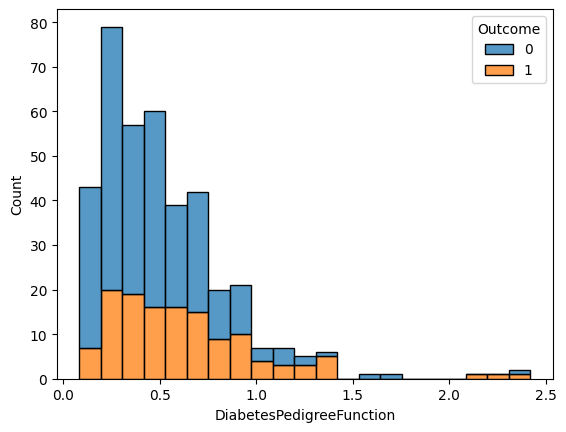

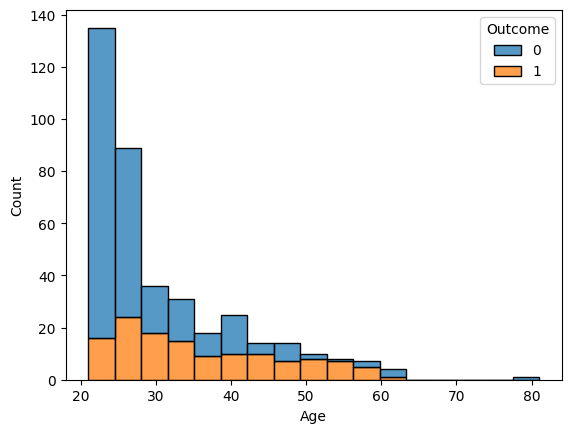

In [11]:
#Plot diabetic status again each features
import matplotlib.pyplot as plt
cols=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
for i in cols:
  sns.histplot(x = i, hue = "Outcome", data = Diabetes_df, multiple = "stack")
  plt.show()

# **Prediction Models**



In [12]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [13]:
#segregate the dependent and independent variable
X = Diabetes_df.drop(columns = ['Outcome'])
y = Diabetes_df['Outcome']

In [14]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=78)
X_train.shape, X_test.shape

((294, 8), (98, 8))

In [15]:
#Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Logistic Regression Model**

In [16]:
#Initialize Model
lr_model = LogisticRegression()

lr_model.fit(X_train_scaled,y_train)

LogisticRegression()

In [17]:
# Predict outcomes for test data set
lr_predictions = lr_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [18]:
# Print the balanced_accuracy score of the model
# YOUR CODE HERE!
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report,accuracy_score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_train, lr_model.predict(X_train_scaled))}")

Balanced Accuracy Score: 0.7324937156928129


In [19]:
# Print the classification report for the model
# YOUR CODE HERE!
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.30      1.00      0.46        29

    accuracy                           0.30        98
   macro avg       0.15      0.50      0.23        98
weighted avg       0.09      0.30      0.14        98



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Achieved a balanced accuracy score of 73% and Accuracy of 73%**

### **Logistic Regression Model with Resampled Training Data**

In [21]:
# Import the RandomOverSampler module from imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
ros_model = RandomOverSampler(random_state = 1)

In [22]:
# Fit the original training data to the random_oversampler model
# YOUR CODE HERE!
X_oversampler, y_oversampler = ros_model.fit_resample(X_train, y_train)

In [23]:
# Count the distinct values of the resampled labels data
# YOUR CODE HERE!|
y_oversampler.value_counts()

0    193
1    193
Name: Outcome, dtype: int64

In [24]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
lr_ros_model = LogisticRegression(random_state = 1)

In [25]:
# Fit the model using the resampled training data
# YOUR CODE HERE!
lr_ros_model.fit(X_oversampler, y_oversampler)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [26]:
# Make a prediction using the testing data
# YOUR CODE HERE!
LR_ros_prediction = lr_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [27]:
# Print the balanced_accuracy score of the model 
# YOUR CODE HERE!
print(f"The Balanced Accuracy Score of the Model is {balanced_accuracy_score(y_test, LR_ros_prediction)}")

The Balanced Accuracy Score of the Model is 0.5


In [28]:
# Print the classification report for the model
# YOUR CODE HERE!
print(classification_report(y_test, LR_ros_prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.30      1.00      0.46        29

    accuracy                           0.30        98
   macro avg       0.15      0.50      0.23        98
weighted avg       0.09      0.30      0.14        98



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Achieved similar Accuracy scores as of LR Model which is 50%**

## **Random Forest Classifier Model**

In [36]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500,max_depth=5, random_state=1)

In [37]:
 # Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [38]:
 # Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [39]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

In [40]:
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.7959183673469388


In [41]:
 # Calculating the confusion matrix
cm_rf_model = confusion_matrix(y_test, rf_predictions)
cm_df_rf_model = pd.DataFrame(
    cm_rf_model, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [42]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        69
           1       0.70      0.55      0.62        29

    accuracy                           0.80        98
   macro avg       0.76      0.73      0.74        98
weighted avg       0.79      0.80      0.79        98



**Achieved 79% Accuracy Score**

## **KNN Classifier Model**

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
 # Instantiate the model with k = 3 neighbors
kn_model = KNeighborsClassifier(n_neighbors=3)

In [45]:
 # Train the model
kn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [46]:
 # Create predictions
kn_y_pred = kn_model.predict(X_test_scaled)

In [47]:
 # Print classification report
print(classification_report(kn_y_pred,y_test))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        70
           1       0.52      0.54      0.53        28

    accuracy                           0.72        98
   macro avg       0.66      0.67      0.67        98
weighted avg       0.73      0.72      0.73        98



**Achieved an accuracy of 72%**

## **Support Vector Machine Linear Classifier Model**

In [48]:
 # Support vector machine linear classifier
from sklearn.svm import SVC

In [49]:
 # Fit to the training data and validate with the test data
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)

In [50]:
 # Calculate classification report
print(classification_report(y_test, svc_predictions)) # Calculate classification report

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        69
           1       0.75      0.62      0.68        29

    accuracy                           0.83        98
   macro avg       0.80      0.77      0.78        98
weighted avg       0.82      0.83      0.82        98



###Accuracy Score is 83%